# Building more complex models in NeuroDyn

## Overview

In the "NeuroDyn model" notebook we have learned how we can define Hodgkin-Huxley and NeuroDyn models, how to simulate them, as well as how to fit the parameters of the NeuroDyn model in order to replicate the biophysical data of the squid giant axon.

Although the forms of the NeuroDyn currents are fixed to the forms of the three currents of the original Hodgkin-Huxley paper, the chip offers full flexibility in defining the dynamics of the gating variables, as well as changing the conductance parameters such as maximal conductances and reversal potentials. This flexibility allows us to use the NeuroDyn equations to replicate different types of neurons. This notebook provides an introduction to understanding how more complex biological neurons can be replicated within the NeuroDyn architecture



## Neuronal bursting

Bursting is one of the fundamental signalling modes of neurons and is ubiquitous in many different types of neurons [ref]. Intrinsic generation of bursts of spikes stems from the interplay of fast processes that generate individual spikes and the slower processes that modulate the spiking behavior and define the burst duration. You can read more about the details of conductance-based modelling of bursting neurons **biophysics notebook**, as well as from a simplified dynamical analysis of reduced neuronal models **iv notebook**.

We have seen in the previous notebook how NeuroDyn can be set up to replicate the spiking behavior of the Hodgkin-Huxley model. In contrast, bursting models of neurons are generally more complex, consisting of several additional ionic currents that modulate the slower burst-generating process. These currents are mostly calcium-dependent and act to initiate and terminate the fast spike-generating processes dictated by the sodium and potassium currents.

Since we cannot add additional ionic currents to a single NeuroDyn neuron, we can achieve a similar affect by **interconnecting** several NeuroDyn neurons through resistive connections or short circuits.

To motivate this, let's first look at an example model of bursting and understand how the slower currents compare to the faster currents of the Hodgkin-Huxley model.

### Example model (Aplysia R-15)

As an example, let's take a look at the Aplysia R-15 bursting neuronal model, a well-studied bursting neuron. The membrane equation has five ionic currents: the leak, sodium and potassium currents that are common to the Hodgkin-Huxley model, and in addition, an inward calcium current and an outward calcium-activated potassium current. The calcium current is slower than the potassium current and its activation has an *excitatory* effect, while the calcium-activated potassium current is significantly slower than this and has a *refractory* effect.

The way we can dissect this is that the the slowest currents generate **slow excitability**, i.e. slow spikes. In turn, these spikes can activate the **fast excitability**, i.e. the sodium + potassium mechanism, that generates spikes during the upstroke of the slow wave. This *slow + fast* structure is what we aim to recreate through interconnection of NeuroDyn neurons.

Let's plot the different variables in order to get a clearer picture of this.

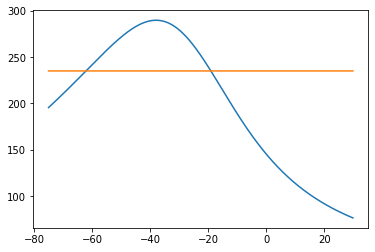

In [139]:
# Aplysia R-15 neuronal model
import matplotlib.pyplot as plt
import numpy as np

# Alpha activation function for variable x
def alphafun(V, x):
    if (x == 'm'):
        y = np.zeros(np.size(V))
        V = np.array(V)
        y[V != 50] = 0.1 * (50 - V) / (np.exp((50 - V)/10) - 1)
        y[V == 50] = 1
        
    if (x == 'h'):
        y = 0.07 * np.exp((25-V)/20)
    
    if (x == 'n'):
        y = np.zeros(np.size(V))
        V = np.array(V)
        y[V != 55] = 0.01 * (55 - V) / (np.exp((55 - V)/10) - 1)
        y[V == 55] = 0.1
            
    return y

# Beta activation function for variable x
def betafun(V, x):
    if (x == 'm'):
        y = 4 * np.exp((25-V)/18)

    if (x == 'h'):
        y = 1 / (np.exp((55-V)/10) + 1)

    if (x == 'n'):
        y = 0.125 * np.exp((45-V)/80)
    
    return y

# x_inf(V) function for variable 'x'
def x_inf(V, x):
    # Define constants for gating variable 'x'
    A = 0.15
    B = -50

    # Shifted voltage constants
    C1 = 127 / 105
    C2 = 8265 / 105
    
    # Constant for Ca dynamics
    Kc = 0.0085
    
    if (x == 'x'):
        y = 1 / (np.exp(A * (B - V)) + 1)
    elif(x == 'c'):
        c = (Kc / (np.exp(A * (B - V)) + 1)) * (Eca - V)
        y = c / (0.5 + c)
    else:
        V = C1*V + C2
        y = alphafun(V,x) / (alphafun(V,x) + betafun(V,x))
    
    return y

# tau(V) function for variable 'x'
def tau(V, x):  
    # Shifted voltage constants
    C1 = 127 / 105
    C2 = 8265 / 105

    if (x == 'x'):
        y = np.ones(np.size(V)) * 235
    elif (x == 'c'):
        y = np.ones(np.size(V)) * 1 / 0.003
    else:
        # If x == 'n' or x == 'h'
        V = C1*V + C2
        y = 12.5 / (alphafun(V,x) + betafun(V,x)) # includes *1/lambda = 12.5
    
    return y

# Maximum conductances in mmho/ cm^2
gna = 4
gk = 0.3
gca = 0.004
gkca = 0.03
gl = 0.003

# Nernst potentials in mV
# Note: resting potential != 0mV, not normalized as in Hodgkin-Huxley
Ena = 30
Ek = -75
Eca = 140
El = -40

V = np.arange(Ek, Ena, 0.1)

#plt.figure()
#plt.plot(V, x_inf(V, 'm'), V, x_inf(V, 'x'))
#plt.plot(V, x_inf(V, 'm'), V, x_inf(V, 'h'), V, x_inf(V, 'n'), V, x_inf(V, 'x'))

plt.figure()
plt.plot(V, tau(V, 'n')*4, V, tau(V, 'x'))

plt.show()

# Constant current stimulus (in uA / cm^2)


## Bursting through interconnection of Hodgkin-Huxley neurons

Let's see how we can construct a bursting neurons throgh an interconnection of Hodgkin-Huxley neurons, by changing the parameters of one of the neurons.

### Load the model

First, let's load the model and the required modules:

In [107]:
import matplotlib.pyplot as plt
from cb_models import HHModel, NeuroDynModel, ShortCircuit

# **Ignore overflow warnings**
import numpy as np
np.warnings.filterwarnings('ignore', 'overflow')

Now let's start by defining two Hodgkin-Huxley neurons and short circuiting them.

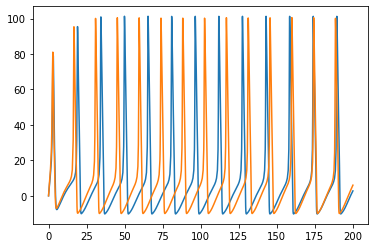

In [158]:
neuron1 = HHModel()
neuron2 = HHModel()

neuron_connection = ShortCircuit([neuron1, neuron2])

T = 200
t = (0, T)

I0 = 8
iapp1 = lambda t: I0
iapp2 = lambda t: 20

x01 = [0,0,0,0]
x02 = x01 + [0,0,0]

sol1 = neuron1.simulate(t, x01, iapp1)
sol2 = neuron_connection.simulate(t, x02, iapp2)

plt.figure()
plt.plot(sol1.t, sol1.y[0])
plt.plot(sol2.t, sol2.y[0])
plt.show()

We see that the interconnection seems to work - we get the same behavior with the two-neuron interconnection as with the original neuron. This is as expected, as all of the parmaeters have been doubled due to the parallel interconnection, hence doubling the applied current should gives us exactly the same behavior as before!

Let's see now if by changing the parameters of the second neuron, we can get the interconnection to burst:

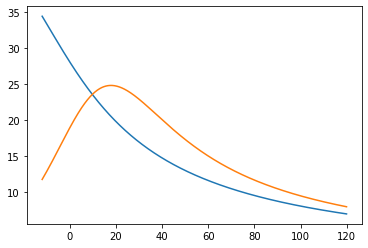

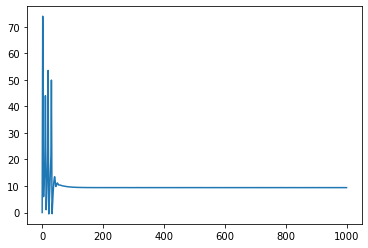

In [199]:
# Set reversal potential for neuron 2 sodium to calcium reversal
neuron2.Ena = 200
neuron2.gna = 1
neuron2.gk = 10

# Turn off leak current for neuron 2 
neuron2.gl = 0

# Turn off h for neuron 2
neuron2.h.bA = 0 # Set beta to 0

# Shift m and n for neuron 2
neuron2.m.aVh = neuron1.m.aVh - 30
neuron2.n.aVh = neuron1.n.aVh - 30

# Scale the timescale for neuron 2 m variable
neuron2.m.aA = neuron1.m.aA / 100
neuron2.m.bA = neuron1.m.bA / 100

# Scale the timescale for neuron 2 n variable
neuron2.n.aA = neuron1.n.aA / 10
neuron2.n.bA = neuron1.n.bA / 10

V = np.arange(neuron1.Ek, neuron1.Ena, 0.1)

plt.figure()
plt.plot(V, neuron2.n.tau(V), V, neuron2.m.tau(V))
plt.show()

T = 700
t = (0, T)

I0 = 70
iapp = lambda t: I0

x0 = [0,0,0,0,0,0,0]

sol = neuron_connection.simulate(t, x0, iapp)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

## Short-circuiting NeuroDyn neurons

Let's try creating a bursting neuron by configuring two NeuroDyn neurons so that the first one provides the fast spike-generating currents, and the second one provides the slow wave-generating currents. We will then short-circuit the two neurons, effectively creating a new neuron with *six* currents ($2x \ [I_l, I_{Na}, I_K]$).

**Remember** that when we short-circuit two neurons like these, the effective membrane capacitance **doubles** due to the parallel interconnection of the membrane capacitors. This effectively doubles the membrane time constant.

Next, let's define two NeuroDyn models with different parameters and short-circuit them:

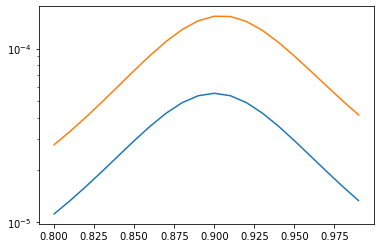

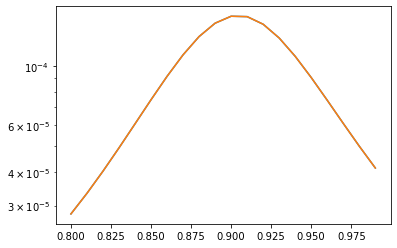

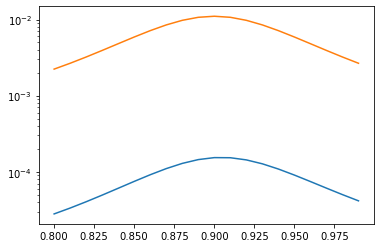

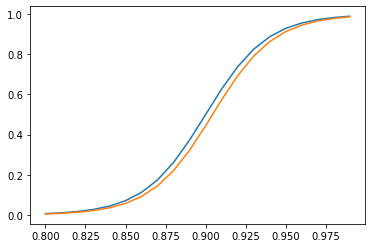

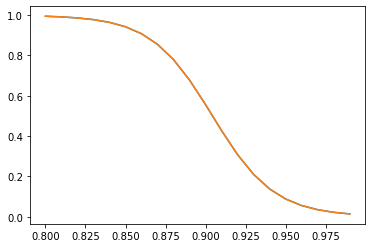

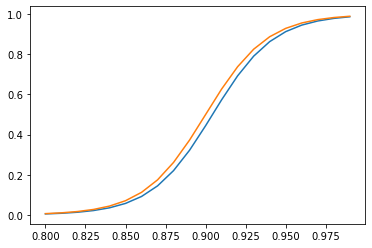

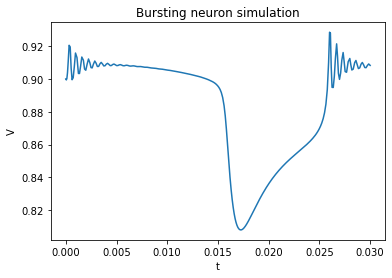

In [109]:
# parameters from joe's simulations

# Maximal conductances
dg1 = np.array([500, 500, 12])
dg2 = np.array([500, 500, 0])

# Reversal potentials
dE1 = np.array([500, -1000, -100])
dE2 = np.array([350, -1000, 0])

# Sigmoid biases
dIbm = np.array([[0, 0, 0, 0, 1000, 0, 0], [0, 0, 1000, 0, 0, 0, 0]])
dIbh = np.array([[0, 0, 400, 0, 0, 0, 0], [0, 0, 0, 0, 320, 0, 0]])
dIbn = np.array([[0, 0, 0, 0, 320, 0, 0], [0, 0, 400, 0, 0, 0, 0]])
dIb1 = [dIbm, dIbh, dIbn]

sf = 2.0
dIbm = np.array([[0, 0, 0, 0, 320, 0, 0], [0, 0, 400, 0, 0, 0, 0]])
dIbh = np.array([[0, 0, 400, 0, 0, 0, 0], [0, 0, 0, 0, 320, 0, 0]])
dIbn = np.array([[0, 0, 0, 0, 10//sf, 0, 0], [0, 0, 10//sf, 0, 0, 0, 0]])

dIb2 = [dIbm, dIbh, dIbn]

# Analog values (same for both)
V_ref = 0.9
I_master = 33e-9
I_voltage = 230e-9
I_ref = 100e-9

# Create two neurons with different parameters
capacitance_scaling = 1 # scale the capacitance to increase the dynamic range

neuron1 = NeuroDynModel(dg1, dE1, dIb1, V_ref, I_voltage, I_master, I_ref, capacitance_scaling)
neuron2 = NeuroDynModel(dg2, dE2, dIb2, V_ref, I_voltage, I_master, I_ref, capacitance_scaling)

# Short circuit the neurons
bursting_neuron = ShortCircuit([neuron1, neuron2])

# Plot the gating variable functions
V = np.arange(V_ref - 0.1, V_ref + 0.1, 0.01)

# Tau functions
plt.figure()
plt.semilogy(V, neuron1.m.tau(V), V, neuron2.m.tau(V))
plt.figure()
plt.semilogy(V, neuron1.h.tau(V), V, neuron2.h.tau(V))
plt.figure()
plt.semilogy(V, neuron1.n.tau(V), V, neuron2.n.tau(V))

# Steady-state functions
plt.figure()
plt.plot(V, neuron1.m.inf(V), V, neuron2.m.inf(V))
plt.figure()
plt.plot(V, neuron1.h.inf(V), V, neuron2.h.inf(V))
plt.figure()
plt.plot(V, neuron1.n.inf(V), V, neuron2.n.inf(V))

I0 = 0e-10
Iapp = lambda t: I0

T = 0.03
trange = (0, T)

sol = bursting_neuron.simulate(trange,[V_ref,0,0,0,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Bursting neuron simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

## Post-inhibitory rebound



In [ ]:
def pulse(t, t_start, t_length, mag):
    I = (t>=t_start)*mag - (t>=(t_start+t_length))*mag
    return I

I0 = -5e-11
Iapp = lambda t: I0 - pulse(t, 0.03, 0.03, 2e-10)

T = 0.1
trange = (0, T)

sol = bursting_neuron.simulate(trange,[V_ref,0,0,0,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Bursting neuron simulation')
plt.plot(sol.t, sol.y[0])
plt.show()